In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from itertools import cycle
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
import warnings
warnings.filterwarnings(action='ignore')
output_notebook()


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns; sns.set() 

import pandas as pd
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
import re
#from sklearn.preprocessing import Imputer
from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt


rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None


Loading BokehJS ...

In [6]:
path_figures = "./images"

In [7]:
def get_float_list(range_max:int, div:int=100) -> list:
    """ To get 0 -> 1, range_max must be same order of mag as div """
    return [float(x)/div for x in range(int(range_max))]

def get_colorcycle(colordict:dict):
    """ Subset cnames with a string match and get a color cycle for plotting """
    return cycle(list(colordict.keys()))

def get_colordict(filter_:str='dark') -> dict:
    """ return dictionary of colornames by filter """
    return dict((k, v) for k, v in cnames.items() if filter_ in k)

def pca_report_interactive(X, scale_X:bool=True, save_plot:bool=True):
    """
    X:          input data matrix
    scale_X:    determine whether to rescale X (StandardScaler) [default: True, X is not prescaled
    save_plot:  save plot to file (html) and not show
    """

    # calculate mean and var
    X_mean, X_var = X.mean(), X.var()
    print('\n*--- PCA Report ---*\n')
    print(f'X mean:\t\t{X_mean:.3f}\nX variance:\t{X_var:.3f}')

    if scale_X:
        # rescale and run PCA
        print("\n...Rescaling data...\n")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_s_mean, X_s_var = X_scaled.mean(), X_scaled.var()
        print(f'X_scaled mean:\t\t{np.round(X_s_mean):.3f}')
        print(f'X_scaled variance:\t{np.round(X_s_var):.3f}\n')
        pca_ = PCA().fit(X_scaled)
        X_pca = PCA().fit_transform(X)
    else:
        # run PCA directly
        print("...Assuming data is properly scaled...")
        pca_ = PCA().fit(X)
        X_pca = PCA().fit_transform(X)
            
    # Get cumulative explained variance for each dimension
    pca_evr = pca_.explained_variance_ratio_
    cumsum_ = np.cumsum(pca_evr)
    
    # Get dimensions where var >= 95% and values for variance at 2D, 3D
    dim_95 = np.argmax(cumsum_ >= 0.95) + 1
    twoD = np.round(cumsum_[1], decimals=3)*100 
    threeD = np.round(cumsum_[2], decimals=3)*100
    instances_, dims_ =  X.shape
    
    # check shape of X
    if dims_ > instances_:
        print("WARNING: number of features greater than number of instances.")
        dimensions = list(range(1, instances_+1))
    else:
        dimensions = list(range(1, dims_+1))
    
    # Print report
    print("\n -- Summary --")
    print(f"You can reduce from {dims_} to {dim_95} dimensions while retaining 95% of variance.")
    print(f"2 principal components explain {twoD:.2f}% of variance.")
    print(f"3 principal components explain {threeD:.2f}% of variance.")
    
    """ - Plotting - """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['PCA'], tooltips=[("dimensions", "@x_dim"), 
                                                ("cumulative variance", "@y_cumvar"),
                                                ("explained variance", "@y_var")])
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # insert 0 at beginning for cleaner plotting
    cumsum_plot = np.insert(cumsum_, 0, 0) 
    pca_evr_plot = np.insert(pca_evr, 0, 0)
    dimensions_plot = np.insert(dimensions, 0, 0)

    """
    ColumnDataSource
    - a special type in Bokeh that allows you to store data for plotting
    - store data as dict (key:list)
    - to plot two keys against one another, make sure they're the same length!
    - below:
        x_dim    # of dimensions (length = # of dimensions)
        y_cumvar # cumulative variance (length = # of dimensions)
        var_95   # y = 0.95 (length = # of dimensions)
        zero_one # list of 0 to 1
        twoD     # x = 2 
        threeD   # x = 3 
    """ 
    
    # get sources
    source_PCA = ColumnDataSource(data=dict(x_dim = dimensions_plot,y_cumvar = cumsum_plot, y_var = pca_evr_plot))    
    source_var95 = ColumnDataSource(data=dict(var95_x = [dim_95]*96, var95_y = get_float_list(96)))
    source_twoD = ColumnDataSource(data=dict(twoD_x = [2]*(int(twoD)+1), twoD_y = get_float_list(twoD+1)))
    source_threeD = ColumnDataSource(data=dict(threeD_x = [3]*(int(threeD)+1), threeD_y = get_float_list(threeD+1)))

    """ PLOT """
    # set up figure and add axis labels
    p = figure(title='PCA Analysis', tools=p_tools)
    p.xaxis.axis_label = f'N of {dims_} Principal Components' 
    p.yaxis.axis_label = 'Variance Explained (per PC & Cumulative)'
    
    # add reference lines: y=0.95, x=2, x=3
    p.line('twoD_x', 'twoD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_twoD) # x=2
    p.line('threeD_x', 'threeD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_threeD) # x=3
    p.line('var95_x', 'var95_y', line_width=2, line_dash='dotted', color='#435363', source=source_var95) # var = 0.95

    # add bar plot for variance per dimension
    p.vbar(x='x_dim', top='y_var', width=.5, bottom=0, color='#D9F2EF', source=source_PCA, name='PCA')
    
    # add cumulative variance (scatter + line)
    p.line('x_dim', 'y_cumvar', line_width=1, color='#F79737', source=source_PCA)
    p.circle('x_dim', 'y_cumvar', size=7, color='#FF4C00', source=source_PCA, name='PCA')

    # change gridlines
    p.ygrid.grid_line_alpha = 0.25
    p.xgrid.grid_line_alpha = 0.25

    # change axis bounds and grid
    p.xaxis.bounds = (0, dims_)
    p.yaxis.bounds = (0, 1)
    p.grid.bounds = (0, dims_)

    # save and show p
    if save_plot:
        output_file(path_figures+'/PCA_analysis.html')
    show(p)
    
    #from bokeh.io import export_svgs
    #p.output_backend = "svg"
    #export_svgs(p, filename=path_figures+'/plot.svg')

    # output PCA info as a dataframe
    df_PCA = pd.DataFrame({'dimension': dimensions, 'variance_cumulative': cumsum_, 'variance': pca_evr}).set_index(['dimension'])
        
    return df_PCA, X_pca, pca_evr


def pca_feature_correlation(X, X_pca, explained_var, features:list=None, fig_dpi:int=150, save_plot:bool=True):
    """
    1. Get dot product of X and X_pca
    2. Run normalizations of X*X_pca
    3. Retrieve df/matrices

    X:               data (numpy matrix)
    X_pca:           PCA
    explained_var:   explained variance matrix
    features:        list of feature names
    fig_dpi:         dpi to use for heatmaps
    save_plot:       save plot to file (html) and not show
    """
    
    # Add zeroes for data where features > instances
    outer_diff = X.T.shape[0] - X_pca.shape[1]
    if outer_diff > 0: # outer dims must match to get sq matrix
        Z = np.zeros([X_pca.shape[0], outer_diff])
        X_pca = np.c_[X_pca, Z]
        explained_var = np.append(explained_var, np.zeros(outer_diff))
    
    # Get correlation between original features (X) and PCs (X_pca)
    dot_matrix = np.dot(X.T, X_pca)
    print(f"X*X_pca: {X.T.shape} * {X_pca.shape} = {dot_matrix.shape}")
    
    # Correlation matrix -> df
    df_dotproduct = pd.DataFrame(dot_matrix)
    df_dotproduct.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
    if any(features): df_dotproduct.index = features    
    
    # Normalize & Sort
    df_n, df_na, df_nabv = normalize_dataframe(df_dotproduct, explained_var, plot_opt=True, save_plot=save_plot)
    
    return df_dotproduct, df_n, df_na, df_nabv


def normalize_dataframe(df, explained_var=None, fig_dpi:int=150, plot_opt:bool=True, save_plot:bool=True):
    """
    1. Get z-normalized df (normalized to µ=0, σ=1)
    2. Get absolute value of z-normalized df
    3. If explained_variance matrix provided, dot it w/ (2)
    """
    # Normalize, Reindex, & Sort
    df_norm = (df.copy()-df.mean())/df.std()
    df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)
    
    # Absolute value of normalized (& sort)
    df_abs = df_norm.copy().abs().set_index(df_norm.index)
    df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)
    
    # Plot
    if plot_opt:
        # Z-normalized corr matrix
        plt.figure(dpi=fig_dpi)
        ax_normal = sns.heatmap(df_norm, cmap="RdBu")
        ax_normal.set_title("Z-Normalized Data")
        if save_plot:
            plt.savefig(path_figures+'/Z_normalized_corr_matrix.pdf', format='pdf')
        else:
            plt.show()

        # |Z-normalized corr matrix|  
        plt.figure(dpi=fig_dpi)
        ax_abs = sns.heatmap(df_abs, cmap="Purples")
        ax_abs.set_title("|Z-Normalized|")
        if save_plot:
            plt.savefig(path_figures+'/Z_normalized_corr_matrix_Abs.pdf', format='pdf')
        else:
            plt.show()
        
    # Re-normalize by explained var (& sort)
    if explained_var.any():
        df_byvar = df_abs.copy()*explained_var
        df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)
        if plot_opt:
            plt.figure(dpi=fig_dpi)
            ax_relative = sns.heatmap(df_byvar, cmap="Purples")
            ax_relative.set_title("|Z-Normalized|*Explained_Variance")
            if save_plot:
                plt.savefig(path_figures+'/Normalized_corr_matrix.pdf', format='pdf')
            else:
                plt.show()
    else:
        df_byvar = None
    return df_norm, df_abs, df_byvar


def pca_rank_features(df_nabv, verbose:bool=True):
    """
    Given a dataframe df_nabv with dimensions [f, p], where:
        f = features (sorted)
        p = principal components
        df_nabv.values are |Z-normalized X|*pca_.explained_variance_ratio_
        
    1. Create column of sum of each row, sort by it 'score_'
    3. Set index as 'rank'
    """
    df_rank = df_nabv.copy().assign(score_ = df_nabv.sum(axis=1)).sort_values('score_', ascending=False)
    df_rank['feature_'] = df_rank.index
    df_rank.index = range(1, len(df_rank)+1)
    df_rank.drop(df_nabv.columns, axis=1, inplace=True)
    df_rank.index.rename('rank', inplace=True)
    if verbose: print(df_rank)
    return df_rank


def pca_full_report(X, features_:list=None, fig_dpi:int=150, save_plot:bool=True):
    """
    Run complete PCA workflow:
        1. pca_report_interactive()
        2. pca_feature_correlation()
        3. pca_rank_features()
        
    X:            data (numpy array)
    features_:    list of feature names
    fig_dpi:      image resolution
    
    """
    # Retrieve the interactive report
    df_pca, X_pca, pca_evr = pca_report_interactive(X, save_plot=save_plot)
    # Get feature-PC correlation matrices
    df_corr, df_n, df_na, df_nabv = pca_feature_correlation(X, X_pca, pca_evr, features_, fig_dpi, save_plot) 
    # Get rank for each feature
    df_rank = pca_rank_features(df_nabv)
    return (df_pca, X_pca, pca_evr, df_corr, df_n, df_na, df_nabv, df_rank)

# SHOHAM DATASET

In [9]:
# Load Dataset
PATH = './DataBase/BDOShohamIML.csv'
Data = pd.read_csv(PATH, names=['Vsl', 'Vsg', 'VisL', 'VisG', 'DenL', 'DenG', 'ST', 'Ang', 'ID', 'Flow Pattern'], header=0)
print(Data['Flow Pattern'].value_counts())

features = ['Vsl', 'Vsg', 'VisL', 'VisG', 'DenL', 'DenG', 'ST', 'Ang', 'ID']
data = np.array(Data[features])
data.shape

I     2905
A     1033
SW     878
DB     594
SS     140
B      125
Name: Flow Pattern, dtype: int64


(5675, 9)


*--- PCA Report ---*

X mean:		112.418
X variance:	98724.729

...Rescaling data...

X_scaled mean:		-0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 9 to 4 dimensions while retaining 95% of variance.
2 principal components explain 58.50% of variance.
3 principal components explain 81.50% of variance.


X*X_pca: (9, 5675) * (5675, 9) = (9, 9)
        score_ feature_
rank                   
1     1.035435      Ang
2     0.970134      Vsg
3     0.898637      Vsl
4     0.765000       ID
5     0.332407     VisL
6     0.332407     VisG
7     0.332407       ST
8     0.332407     DenG
9     0.332407     DenL


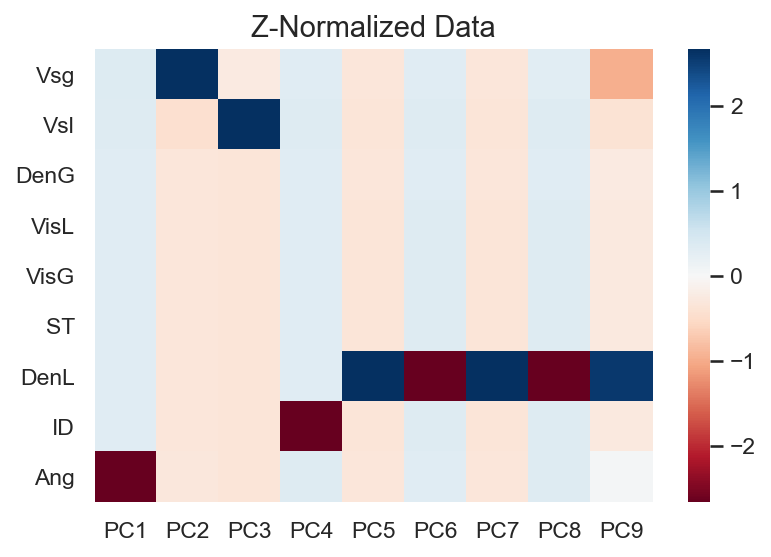

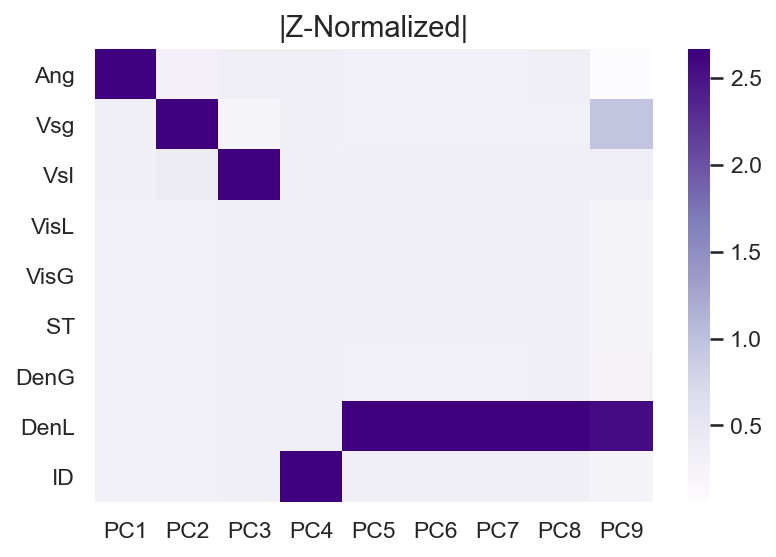

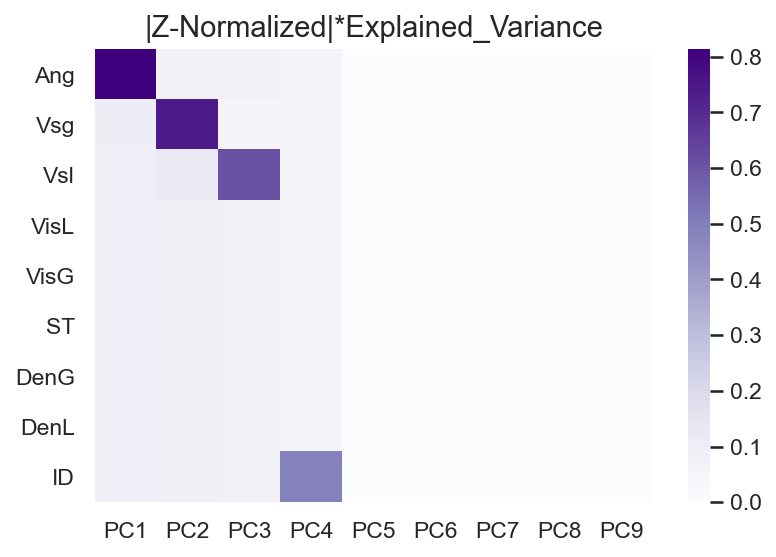

In [10]:
MPF_outputs = pca_full_report(X=data, features_= features)

# 12 DATASETS

In [12]:
# Load Dataset
PATH = './DataBase/New_BD12Exp6FP.csv'
Data = pd.read_csv(PATH, names=['Vsl', 'Vsg', 'VisL', 'VisG', 'DenL', 'DenG', 'ST', 'Ang', 'ID', 'Flow Pattern'], header=0)
print(Data['Flow Pattern'].value_counts())

features = ['Vsl', 'Vsg', 'VisL', 'VisG', 'DenL', 'DenG', 'ST', 'Ang', 'ID']
data = np.array(Data[features])
data.shape

4    4721
3    1664
2    1093
0     816
1     582
5     153
Name: Flow Pattern, dtype: int64


(9029, 9)


*--- PCA Report ---*

X mean:		107.662
X variance:	90540.517

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 9 to 8 dimensions while retaining 95% of variance.
2 principal components explain 39.70% of variance.
3 principal components explain 53.50% of variance.


X*X_pca: (9, 9029) * (9029, 9) = (9, 9)
        score_ feature_
rank                   
1     0.895709     DenL
2     0.717565      Ang
3     0.663087       ST
4     0.584454      Vsg
5     0.554146     DenG
6     0.544804      Vsl
7     0.517573     VisL
8     0.436609       ID
9     0.419690     VisG


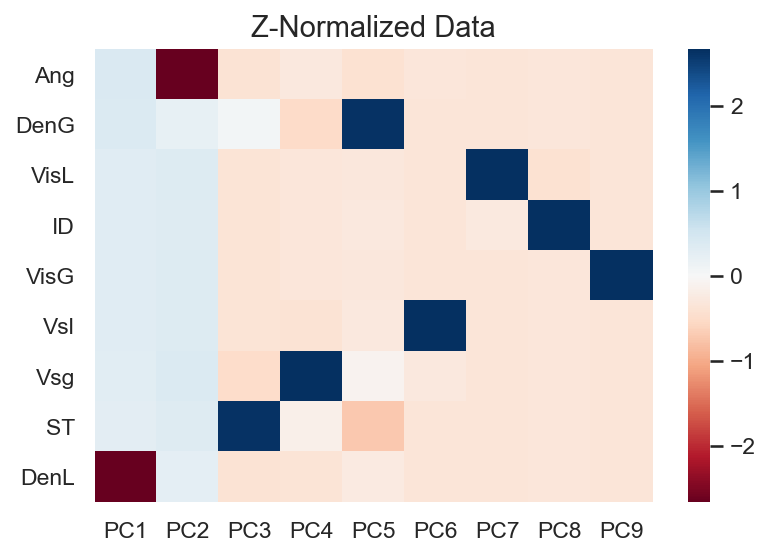

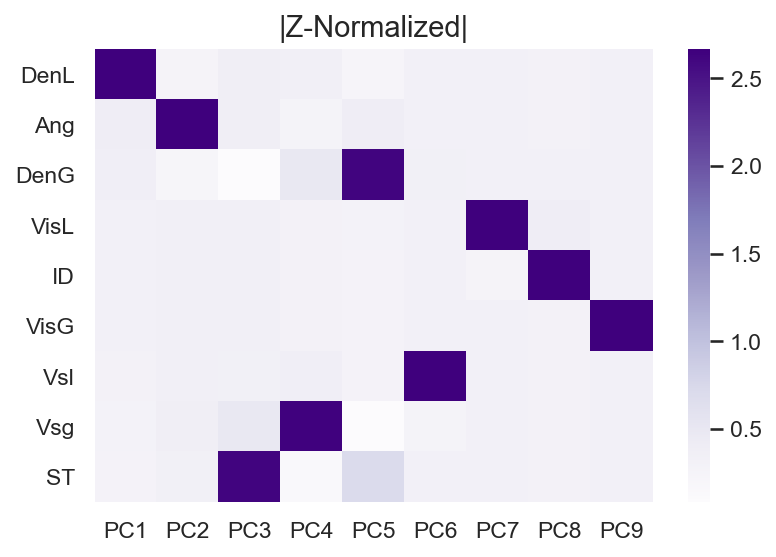

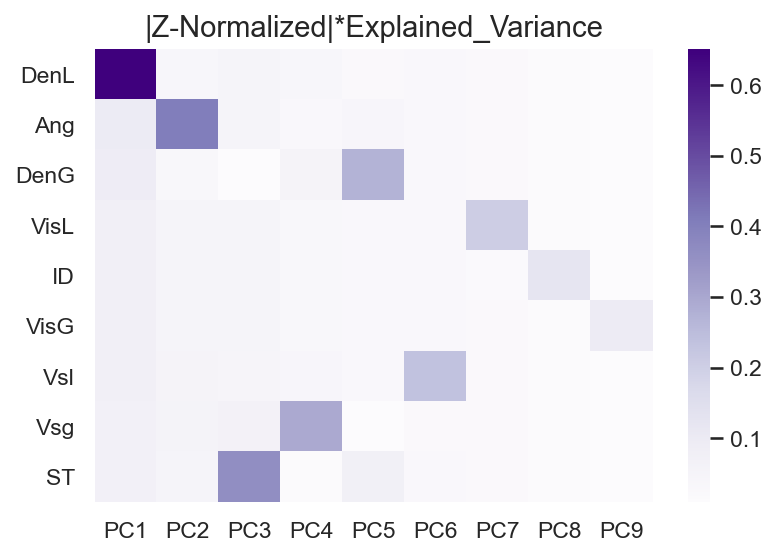

In [13]:
MPF_outputs = pca_full_report(X=data, features_= features)